# Pendulum Motion
### Author: Neil Tramsen
### Group Members: Anisa Hofert, Duncan Guy, Christina Jordan 
In this project, we analyse the motion of a pendulum subject to dampening as well as a periodic driving force. The motion will be formulated as a differential equation, and solved using a number of integrating different algorithms, allowing us to determine their accuracy. We will then analyse which parameters lead to predictable oscillations, and which lead to chaotic motion.  

## Problem Analysis

### Physical Considerations

A pendulum swings back and forth due to a restoring torque that acts perpendicular to the string. This restoring torque is provided by the component of gravity that is perpendicular to the position of the pendulum from the point about which it is rotating. In addition to the restoring torque, a resistive torque proportional to the angular velocity and a driving force also act on the pendulum. The pendulum will be modelled as a mass on the end of a massless, solid rod, allowing the pendulum to move anywhere on the perimeter of a circle.

The motion of a swinging pendulum is goverened by a number of parameters. The undriven pendulum's motion can be defined as a second order differential equation, depending on the length of the pendulum, the downward acceleration due to gravity, g, and a coefficient of drag. Exerting a periodic driving force on a pendulum will drastically alter its motion, with its motion now also dependent on the frequency of the driving force, the amplitude of the driving force, as well as the mass on the end of the pendulum, on which the driving force is acting.

We will limit the initial angular displacement to be between 0 and $\pi$, where 0 is the equilibrium point when the pendulum hangs straight down. The length and mass of the pendulum must both be greater than 0. The frequency of the driving force must also be greater than or equal to 0.

### Coding Considerations

This model is a time-dependent model, as tracks angular positions and velocities as they develop over time, and it is deterministic as the solution is only dependent on the intial conditions, such as the length, the characteristics of the driving force, and drag-coefficient. This means that identical initial conditions will produce identical outputs. The variables are continiuous, as both angular position and velocity will move through a continuous range of values over time. To initialize the problem we will need to specify the length of the pendulum, the mass of the pendulum, the coefficient of drag, the driving forces amplitude, and the driving forces angular frequency, $\omega_D$. The acceleration due to gravity is $9.81 ms^{-1}$.

We will solve the differential equation using 3 different numerical integrating algorithms. The first is the Euler method, which has an error associated with it that is proportional to the time steps, $\delta t$. The second is the Runge-Kutta Method, which has an associated error of $\delta t^2$. The third is the Scipi odeint library, which uses a faster and more andvanced algorithm to calculate the most accurate result. We will compare the algorithms and the errors they produce.

## Model Development

The rotational analog to Newton's second law is 

$$T = I^2\alpha.$$

There are three torques acting on the pendulum, a drag force which is proportional to the angular speed, the component of gravity perpendicular to the string, and the driving force.

$$I^2\alpha = -mgl\sin{(\theta)}-bl\omega+A\cos{(\omega_Dt)}$$

The rotational inertia of a pendulum is $I = ml^2$. Furthermore, $\omega$ and $\alpha$ are the first and second derivatives of the angle of displacement, $\theta$.

$$ml^2\ddot{\theta}+bl\dot{\theta}+mgl\sin{(\theta)}=A\cos{(\omega_Dt)}$$

$$\ddot{\theta}+\frac{b}{ml}\dot{\theta}+\frac{g}{l}\sin{(\theta)}=\frac{A}{ml^2}\cos{(\omega_Dt)}$$

This complicated differential equation of multiple variables can be converted to a system of 3 first order differential equations.

$$\begin{cases}
\frac{d\omega}{dt}=-\alpha\omega-\beta\sin{(\theta)}+\gamma\cos{(\phi)}\\\frac{d\theta}{dt}=\omega\\\frac{d\phi}{dt}=\omega_D
\end{cases}$$

This is the set of differential equations that our pendulum function will represent, where $\alpha$, $\beta$, and $\gamma$ are constants to be calculated based on the parameters that the user inputs.

## Model Implementation

### Initialising Python

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import time

### Checking Parameters and calculating constants based on parameters

In [2]:
# length of string and mass must be greater than 0
# Driving amplitude and drag factor must be greater than or equal to 0
def ParameterCheck(length, mass, AmplitudeD, dragFactor, wD):
    """
    This function checks the parameters for the pendulum are valid. Returns true if valid, returns false otherwise.
    
    ParameterCheck(length, mass, AmplitudeD, dragFactor, wD)
    
    """
    if mass<=0 or length<=0:
        return False
    if AmplitudeD<0 or dragFactor<0 or wD<0:
        return False
    return True

# Definition calculates the constants required for the differential equation
# based on parameters
def Parameters(length, mass, AmplpitudeD, dragFactor, wD):
    """
    This function calculates the constants required by the Pendulum function. Returns 4 constants as a tuple.
    
    Parameters(length, mass, AmplpitudeD, dragFactor, wD)
    
    """
    a = dragFactor/(mass*length)
    b = 9.81/length
    c = AmplitudeD/(mass*length*length)
    
    return a,b,c,wD

def InitialConditionsCheck(x0):
    """
    This function checks the initial conditions for the pendulum are valid. Returns true if valid, returns false otherwise.
    
    ParameterCheck(x0)
    
    x0 is an array of 3 intitial conditions: [[omega, theta, wD]]
    
    """
    if x0[0]<0:
        return False
    if x0[1]<0 or x0[1]>np.pi:
        return False
    if x0[2]<0:
        return False
    return True

### Pendulum Function

In [3]:
def Pendulum(variable, t, a, b, c, wD):
    """
    This function returns the development over time of a driven pendulum.
    
    Pendulum(position((omega, theta, phi)), time, args)
    
    position: an array containing the value of omega, theta, and phi
    time: unused
    args: a, b ,c, wD - constants as defined in the model development
    
    """
    
    dw = -1*a*variable[0]-b*np.sin(variable[1])+c*np.cos(variable[2])
    dtheta = variable[0]
    dphi = wD
    
    return np.array((dw,dtheta,dphi))

### Integrators

In [4]:
def EulerSystem(xPrime, x0, t, args=()):
    """
    Solves a system of ODEs using the Euler method.
    
    EulerSystem(xPrime,t0=0.0,x0=0.0,T=1.0,dt=0.1)
        xPrime -- the system to be integrated, returns the array of derivatives
        t -- the array of time points where the solution is needed; the zeroth entry corresponds to x0
        x0 -- initial condition
        
    Note that we do not ask for dt in this implementation of the algorithm
    """
    
    x = np.zeros((t.size, x0.size))
    x[0,:] = x0
    for i in range(1, t.size):
        dt = t[i] - t[i-1]
        x[i,:] = x[i-1,:] + dt * xPrime(x[i-1,:],t[i-i],*args)

    return x

def RK2(xPrime, x0,t,args=()):
    """
    solves systems of ode using RK2
    RK2(xPrime, x0 = 0.0, T= 1.0, dt= 0.1)
        xPrime --the differential equation
        t -- the array of tie points where the solution is needed 
        xo-- initial condition
    """
    x = np.zeros((t.size, x0.size))
    x[0,:]=x0
    for i in range(1, t.size):
        fx = xPrime(x[i-1,:], t[i-1], *args)
        guess = x[i-1,:]+dt*fx
        fxdx = xPrime(guess,t[i-1],*args)
        x[i,:] = x[i-1,:]+0.5*(fx+fxdx)*dt
    return x

## Comparing Algorithm run times and errors

### Run time comparison

In [5]:
# constants initialization
length = 1
mass = 1
AmplitudeD = 2
dragFactor = 1
wD = 2
dt = 1e-3 # time step
SimulationTime = 10.0 # time to solve for

# initial conditions
x0 = np.array((0,1,0)) # starting at max displacement

# calculation of parameters

if ParameterCheck(length, mass, AmplitudeD, dragFactor, wD) and InitialConditionsCheck(x0):
    x = Parameters(length, mass, AmplitudeD, dragFactor, wD)

    t=np.arange(0,SimulationTime,dt)

    # comapring run times
    tt1 = time.time()
    xEuler = EulerSystem(Pendulum, x0, t, args=(x))
    tt2 = time.time()
    xRK2 = RK2(Pendulum, x0, t, args=(x))
    tt3 = time.time()
    xOdeInt = odeint(Pendulum, x0, t, args=(x))
    tt4 = time.time()

    print('Euler took ', tt2-tt1, 's to run.')
    print('RK2 took ', tt3-tt2, 's to run.')
    print('Odeint took ', tt4-tt3, 's to run.')
else:
    print("There is an error in your initial conditions.")

Euler took  0.22945833206176758 s to run.
RK2 took  0.3876183032989502 s to run.
Odeint took  0.018558502197265625 s to run.


### Error Analysis

Text(0, 0.5, 'absolute error')

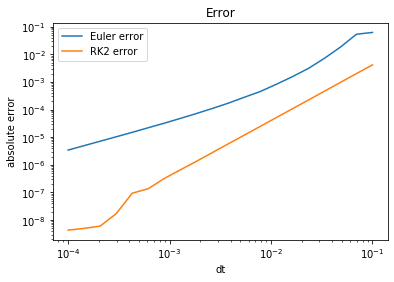

In [6]:
dts = np.logspace(-1, -4, 20)
PendulumE = np.zeros(dts.size)
PendulumRK2 = np.zeros(dts.size)
PendulumOdeInt = np.zeros(dts.size)

for i in range(dts.size):
    dt =dts[i]
    t=np.arange(0,SimulationTime,dts[i])
    
    P = EulerSystem(Pendulum, x0, t, args=(x))[:,1]
    PendulumE[i] = P[-1]
    P = RK2(Pendulum, x0, t, args=(x))[:,1]
    PendulumRK2[i] = P[-1]
    P = odeint(Pendulum, x0, t, args=(x))[:,1]
    PendulumOdeInt[i] = P[-1]

ErrorE = PendulumE - PendulumOdeInt
ErrorRK2 = PendulumRK2 - PendulumOdeInt

plt.loglog(dts, np.abs(ErrorE),label='Euler error')
plt.loglog(dts, np.abs(ErrorRK2), label='RK2 error')
plt.legend()
plt.title("Error")
plt.xlabel('dt')
plt.ylabel('absolute error')

As predicted, the RK2 Method has a smaller absolute error when integrating over a time period. It also makes sense that the RK2 error has a steeper gradient, as error is proportional to $dt^2$, whereas Euler's error is proportional to $dt$. Also, the smaller, $dt$, is the more accurate the result, as making the smaller steps in time decreases the relative error for each step.

## Comparing Phase Portraits

We will analyse the phase portraits of a pendulum with a small initial angular displacement, and no driving force. This will become important for our model verification later on.

#### Constant Initialisation

In [7]:
# constant initialisation
length = 1
mass = 1
AmplitudeD = 0 # we will compare the phase portraits of an undriven pendulum
dragFactor = 0
wD = 0
if not ParameterCheck(length, mass, AmplitudeD, dragFactor, wD):
    print("Enter valid parameters.")
n=101 # resolution of phase portraits

#### Undamped Pendulum

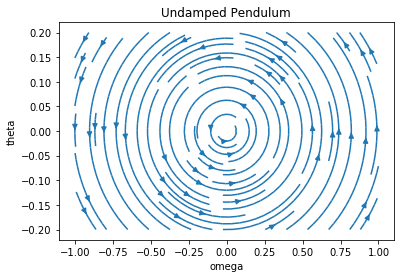

In [8]:
#No damping
# calculation of parameters
x = Parameters(length, mass, AmplitudeD, dragFactor, wD)

xcoords = np.linspace(-1,1, n)
ycoords = np.linspace(-0.2, 0.2, n)
X, Y = np.meshgrid (xcoords, ycoords)
Vx, Vy = Pendulum((X, Y, 0), 0, *x)[0],Pendulum((X, Y, 0), 0, *x)[1]
p=plt.streamplot(X,Y,Vx,Vy)
plt.xlabel('omega')
plt.ylabel('theta')
plt.title('Undamped Pendulum')
plt.show()

When there is no damping at all, the solution will keep moving around in cycles, as there is nothing to hinder motion, hence the circular cycles in the ohase portrait.

#### Underdamped Pendulum

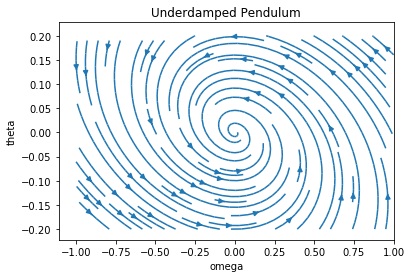

In [9]:
#Underdampened
dragFactor = 1.5
# calculation of parameters
x = Parameters(length, mass, AmplitudeD, dragFactor, wD)

xcoords = np.linspace(-1,1, n)
ycoords = np.linspace(-0.2, 0.2, n)
X, Y = np.meshgrid (xcoords, ycoords)
Vx, Vy = Pendulum((X, Y, 0), 0, *x)[0],Pendulum((X, Y, 0), 0, *x)[1]
p=plt.streamplot(X,Y,Vx,Vy)
plt.xlabel('omega')
plt.ylabel('theta')
plt.title('Underdamped Pendulum')
plt.show()

When underdamped, the solution will oscillate but eventually tend to 0, hence the limit cycle in the phase portrait.

#### Overdamped Pendulum

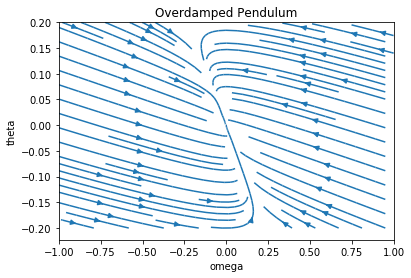

In [10]:
#Overdampened
dragFactor = 10
# calculation of parameters
x = Parameters(length, mass, AmplitudeD, dragFactor, wD)

xcoords = np.linspace(-1,1, n)
ycoords = np.linspace(-0.2, 0.2, n)
X, Y = np.meshgrid (xcoords, ycoords)
Vx, Vy = Pendulum((X, Y, 0), 0, *x)[0],Pendulum((X, Y, 0), 0, *x)[1]
p=plt.streamplot(X,Y,Vx,Vy)
plt.xlabel('omega')
plt.ylabel('theta')
plt.title('Overdamped Pendulum')
plt.show()

When overdamped, there is no oscillation, and all solutions tend to 0.

#### Critically Damped Pendulum

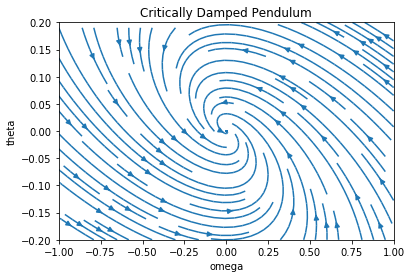

In [11]:
#Critically damed
dragFactor = np.sqrt(9.81)
# calculation of parameters
x = Parameters(length, mass, AmplitudeD, dragFactor, wD)

xcoords = np.linspace(-1,1, n)
ycoords = np.linspace(-0.2, 0.2, n)
X, Y = np.meshgrid (xcoords, ycoords)
Vx, Vy = Pendulum((X, Y, 0), 0, *x)[0],Pendulum((X, Y, 0), 0, *x)[1]
p=plt.streamplot(X,Y,Vx,Vy)
plt.xlabel('omega')
plt.ylabel('theta')
plt.title('Critically Damped Pendulum')
plt.show()

When critically damped, all the solutions will take the quickest path to 0. This occurrs when the drag factor is equal to the natural frequency of the pendulum.

#### The relationship between damping factor and omega

To determine which drag coefficient is most effective at daming this system, we will plot the absolute value of displacement after 2 seconds of motion against the value of the drag factor. The samller the displacement, the more effective the damping.

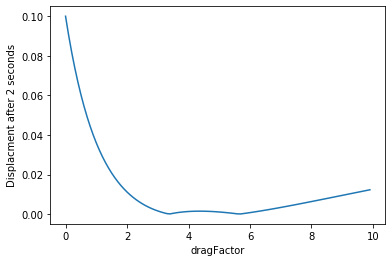

In [12]:
# constants initialization
length = 1
mass = 1
AmplitudeD = 0
dragFactor = 5.4
wD = 0
dt = 1e-4 # time step
SimulationTime = 2.0 # time to solve for

# initial conditions
x0 = np.array((0,0.1,0)) # starting at max displacement

# calculation of parameters

t=np.arange(0,SimulationTime,dt)

Amplitudes = np.zeros(100)
dragFactors = np.zeros(100)
for i in range(100):
    dragFactor=0.1*i
    dragFactors[i]=dragFactor
    x = Parameters(length, mass, AmplitudeD, dragFactor, wD)
    xOdeInt = odeint(Pendulum, x0, t, args=(x))
    Amplitudes[i]=np.abs(xOdeInt[19999,1])
    
plt.plot(dragFactors, Amplitudes)
plt.xlabel("dragFactor")
plt.ylabel("Displacment after 2 seconds")
plt.show()
    

The above graph shows that critical damping for this system ocurrs at around b=5.4, as this is where the pendulum has minimum displacement after 2 seconds. The minimum at 3.3 is not due to critical to damping, but due to the fact, that an integer number of oscillations occurrs after 2 seconds, so the amplitude is 0 anyway.

## Comparing run time and accuracy of integrators

### Chaotic Motion

Chaotic motion is defined as unpredictable development of a system. In a pendulum, changing the initial parameters by a certain amount, $\Delta x$, causes a change in the subsequent motion on the order of $\Delta x$. The Pendulum is moving chaotically when the change in motion itself is constantly changing, and there is no resemblance to a $\Delta x$.

C:\Users\neilt\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


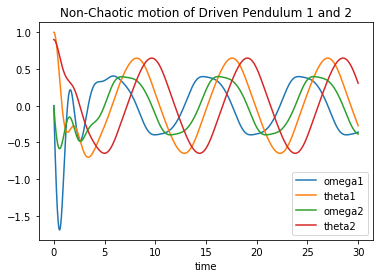

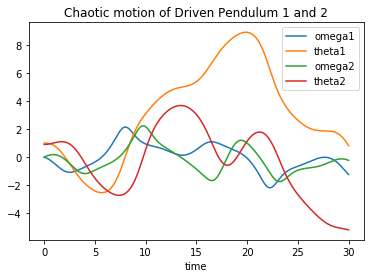

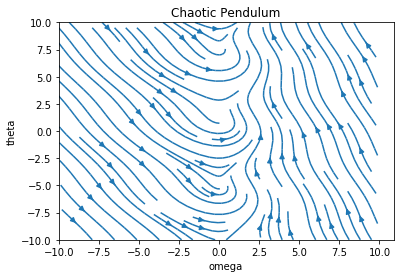

In [13]:
length = 1
mass = 1
AmplitudeD = 4*np.sqrt(2)
dragFactor = 1.5
wD = 2/3
dt = 1e-4 # time step
SimulationTime = 30.0 # time to solve for

# initial conditions
x0 = np.array((0,1,1)) # starting at max displacement
x1 = np.array((0, 0.9, 0))

if ParameterCheck(length, mass, AmplitudeD, dragFactor, wD) and InitialConditionsCheck(x0):
    # calculation of parameters
    x = Parameters(length, mass, AmplitudeD, dragFactor, wD)

    t=np.arange(0,SimulationTime,dt)


    x1OdeInt = odeint(Pendulum, x0, t, args=(x))
    x2OdeInt = odeint(Pendulum, x1, t, args=(x))

    plt.plot(t, x1OdeInt[:,0],label='omega1')
    plt.plot(t, x1OdeInt[:,1],label='theta1')
    plt.xlabel("time")
    plt.title("Non-Chaotic motion of Driven Pendulum 1 and 2")

    plt.plot(t, x2OdeInt[:,0],label='omega2')
    plt.plot(t, x2OdeInt[:,1],label='theta2')
    plt.legend()
    plt.show()

    c = 1.13
    x = 0.5,1,c,2/3

    x1OdeInt = odeint(Pendulum, x0, t, args=(x))
    x2OdeInt = odeint(Pendulum, x1, t, args=(x))

    plt.plot(t, x1OdeInt[:,0],label='omega1')
    plt.plot(t, x1OdeInt[:,1],label='theta1')
    plt.xlabel("time")
    plt.title("Chaotic motion of Driven Pendulum 1 and 2")

    plt.plot(t, x2OdeInt[:,0],label='omega2')
    plt.plot(t, x2OdeInt[:,1],label='theta2')
    plt.legend()
    plt.show()

    xcoords = np.linspace(-10,10, n)
    ycoords = np.linspace(-10, 10, n)
    X, Y = np.meshgrid (xcoords, ycoords)
    Vx, Vy = Pendulum((X, Y, 0), 0, *x)[0],Pendulum((X, Y, 0), 0, *x)[1]
    p=plt.streamplot(X,Y,Vx,Vy)
    plt.xlabel('omega')
    plt.ylabel('theta')
    plt.title('Chaotic Pendulum')
    plt.show()
else:
    print("Enter valid initial parameters.")



## Model Verification

### Test Cases

One way of verifying the model is testing it for some initial conditions for which the result is known. We will test some easily verifyable expected solutions, by changing the initial conditions to specific values.
- if the initial angle of displacment is 0, the initial angular speed is 0, and the driving force is 0, there is no movement, which makes sense as the pendulum would remain hanging in equilibrium. The same ocurrs when the initial angle is equal to $\pi$, as this just means the pendulum is upside down and in equilibrium.
- For driving torques with frequrencies on the order of the pendulum's natural frequency, the pendulum will always oscillate at the frequency of the driving force after a small adjustment period. This makes sense because for each oscillation of the driving force, the pendulum will be shifted a little more "in synchronisation" with the driving force, until their motions are completely synchronised.

### Simple Harmonic Motion

One way to verufy the code is to see whether it agrees with the known results of simple harmonic motion. For a pendulum to move in simple harmonic motion, the driving force must be 0, and the maximum angle of displacement must be kept small, so that 

$$\sin{(\theta)}\approx\theta.$$

This converts the differential equation into an ordinary differential equation that is easily solvable:

$$\ddot{\theta}+\frac{b}{ml}\dot{\theta}+\frac{g}{l}\theta=0$$

$$\ddot{\theta}+2\beta\dot{\theta}+\omega^2\theta=0$$

$$\theta = e^{-\beta}\left(c_1e^{\sqrt{\beta^2-\omega^2}t}+c_2e^{-\sqrt{\beta^2-\omega^2}t}\right)$$

If $\beta = 0$:$$\theta = A\cos{(\omega t)}+B\sin{(\omega t)}$$
This leads to continuous oscillatory motion of the particle, as expected when there is no drag.

If $\beta < \omega$:$$\theta = e^{-\beta t}\left[A\cos{(\omega t)}+B\sin{(\omega t)}\right]$$
This leads to oscillatory motion, but the oscillations will continually grow smaller until motion stops. This is underdamping.

If $\beta = \omega$: $$\theta = Ae^{-\beta t}$$
In this case the solution to the equation is just the negative exponential, which is the solution for critical damping.

If $\beta > \omega$:$$\theta = e^{-\beta}\left(c_1e^{x_1t}+c_2e^{x_2t}\right)$$
Both $x_1$ and $x_2$ are less than $\beta$, so the fucntion still decays to 0 as time goes on, but it will do so more slowly than in the critical damping case. This is overdamping.

Our function exhibits all these properties, as shown in the phase portraits in the phase portraits when there is no driving force, shown above. Furthermore, we defined $\omega$ as $\sqrt{\frac{g}{l}}$, which allows us to calculate the time period. If we run one of our integrators for exactly that time period, and start $\theta$ at its maximum, we should see $\theta$ return to its maximum at the end of the time period, and we should see exactly one period of motion.

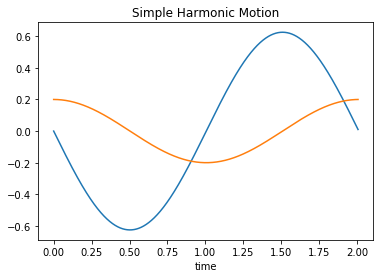

In [14]:
# constants initialization
length = 1
mass = 1
AmplitudeD = 0
dragFactor = 0
wD = 0
dt = 1e-4 # time step
SimulationTime = 2.006 # time to solve for

# omega = sqrt(9.81), so T = 2*pi/sqrt(9.81). T is the simukation time.

# initial conditions
x0 = np.array((0,0.2,0)) # starting at max displacement

if ParameterCheck(length, mass, AmplitudeD, dragFactor, wD) and InitialConditionsCheck(x0):
    # calculation of parameters
    x = Parameters(length, mass, AmplitudeD, dragFactor, wD)
    t=np.arange(0,SimulationTime,dt)

    xOdeInt = odeint(Pendulum, x0, t, args=(x))

    plt.plot(t, xOdeInt[:,0],label='omega')
    plt.plot(t, xOdeInt[:,1],label='theta')
    plt.xlabel("time")
    plt.title("Simple Harmonic Motion")
else:
    print("Enter valid initial conditions.")

As expected, the pendulum oscillates exactly once during its time period.

## Discussion and Conclusion

The Euler, Runge-Kutta, and OdeInt methods all find plausible solutions for the angular position and velocity of a pendulum over time, with errors and processing times which have been thouroughly analyzed. The pendulum function was verified by approximating the pendulum's motion as simple harmonic motion, for which the algorithm outputted matching results. We explained the phase planes for the undriven pendulum, which also support the simple harmonic motion model, and have found cases for which the driven oscillator behaves chaotically. This program can be used to accurately model the development of a pendulum over time, something which is analytically very hard, and sometimes even impossible, to do. 